In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_validate_data():
    """Load data with error handling and validation"""
    try:
        train_df = pd.read_csv('../data/raw/train.csv')
        test_df = pd.read_csv('../data/raw/test.csv')
        sample_sub = pd.read_csv('../data/raw/sample_submission.csv')
        
        print("✅ Data loaded successfully")
        return train_df, test_df, sample_sub
    
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        print("Please ensure data files are in the correct directory")
        return None, None, None

def explore_data(train_df, test_df, sample_sub):
    """Comprehensive data exploration with visualizations"""
    print("=" * 60)
    print("📊 DATASET OVERVIEW")
    print("=" * 60)
    
    # Basic info
    print(f"Training samples: {len(train_df):,}")
    print(f"Test samples: {len(test_df):,}")
    print(f"Sample submission shape: {sample_sub.shape}")
    print(f"\nTraining columns: {train_df.columns.tolist()}")
    
    # Target analysis (using correct column name)
    target_dist = train_df['rule_violation'].value_counts(normalize=True)
    class_imbalance = (1 - target_dist.min()) * 100
    
    print(f"\n🎯 TARGET DISTRIBUTION (rule_violation):")
    print(target_dist)
    print(f"Class imbalance: {class_imbalance:.1f}%")
    
    # Subreddit analysis
    print(f"\n🏘️ SUBREDDIT DISTRIBUTION:")
    subreddit_dist = train_df['subreddit'].value_counts()
    print(f"Unique subreddits: {train_df['subreddit'].nunique()}")
    print(subreddit_dist.head(10))
    
    # Rule analysis  
    print(f"\n📋 RULE ANALYSIS:")
    print(f"Unique rules: {train_df['rule'].nunique()}")
    rule_dist = train_df['rule'].value_counts()
    print(rule_dist.head(10))
    
    # Missing values analysis
    print(f"\n🔍 MISSING VALUES:")
    missing_train = train_df.isnull().sum()
    missing_test = test_df.isnull().sum()
    
    print("Training set:")
    print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "No missing values")
    print("Test set:")
    print(missing_test[missing_test > 0] if missing_test.sum() > 0 else "No missing values")
    
    return target_dist, class_imbalance

def analyze_text_features(train_df):
    """Analyze text characteristics and create visualizations"""
    print("\n📝 TEXT ANALYSIS:")
    
    # Efficient text statistics (using correct column name)
    train_df['text_length'] = train_df['body'].str.len()
    train_df['word_count'] = train_df['body'].str.split().str.len()
    train_df['avg_word_length'] = train_df['text_length'] / train_df['word_count']
    
    # Summary statistics
    text_stats = train_df[['text_length', 'word_count', 'avg_word_length']].describe()
    print(text_stats)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Text length distribution by target
    sns.boxplot(data=train_df, x='rule_violation', y='text_length', ax=axes[0,0])
    axes[0,0].set_title('Text Length by Rule Violation')
    axes[0,0].set_yscale('log')
    
    # Word count distribution
    sns.histplot(data=train_df, x='word_count', hue='rule_violation', bins=50, ax=axes[0,1], alpha=0.7)
    axes[0,1].set_title('Word Count Distribution')
    axes[0,1].set_xlim(0, min(200, train_df['word_count'].max()))
    
    # Average word length
    sns.boxplot(data=train_df, x='rule_violation', y='avg_word_length', ax=axes[1,0])
    axes[1,0].set_title('Average Word Length by Rule Violation')
    
    # Target distribution pie chart
    target_counts = train_df['rule_violation'].value_counts()
    axes[1,1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%')
    axes[1,1].set_title('Rule Violation Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis specific to this dataset
    print("\n🔍 DATASET-SPECIFIC ANALYSIS:")
    
    # Analyze rule violations by subreddit
    violation_by_sub = train_df.groupby('subreddit')['rule_violation'].agg(['count', 'mean']).sort_values('count', ascending=False)
    print("\nRule violations by subreddit (top 10):")
    print(violation_by_sub.head(10))
    
    # Analyze rule violations by rule type
    violation_by_rule = train_df.groupby('rule')['rule_violation'].agg(['count', 'mean']).sort_values('count', ascending=False)
    print(f"\nRule violations by rule type (top 10):")
    print(violation_by_rule.head(10))
    
    return text_stats

def preprocess_text(text):
    """Enhanced text preprocessing"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Reddit-specific mentions (u/, r/)
    text = re.sub(r'[ur]/\w+', '', text)
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def build_baseline_model(train_df, test_df):
    """Build and evaluate baseline TF-IDF + Logistic Regression model"""
    print("\n🤖 BUILDING BASELINE MODEL:")
    print("-" * 40)
    
    # Preprocess text (using correct column name)
    print("Preprocessing text...")
    train_df['clean_text'] = train_df['body'].apply(preprocess_text)
    test_df['clean_text'] = test_df['body'].apply(preprocess_text)
    
    # TF-IDF Vectorization with optimized parameters
    tfidf = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words='english',
        sublinear_tf=True
    )
    
    print("Fitting TF-IDF vectorizer...")
    X = tfidf.fit_transform(train_df['clean_text'])
    y = train_df['rule_violation']  # Using correct column name
    
    print(f"TF-IDF matrix shape: {X.shape}")
    
    # Cross-validation with multiple metrics
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    lr_model = LogisticRegression(
        class_weight='balanced', 
        max_iter=1000,
        random_state=42,
        solver='liblinear'
    )
    
    print("Performing cross-validation...")
    f1_scores = cross_val_score(lr_model, X, y, cv=cv, scoring='f1_macro')
    accuracy_scores = cross_val_score(lr_model, X, y, cv=cv, scoring='accuracy')
    
    print(f"Baseline CV F1-macro: {f1_scores.mean():.4f} (±{f1_scores.std():.4f})")
    print(f"Baseline CV Accuracy: {accuracy_scores.mean():.4f} (±{accuracy_scores.std():.4f})")
    
    return lr_model, tfidf, X, y

def create_submission(lr_model, tfidf, X, y, test_df, sample_sub):
    """Train final model and create submission"""
    print("\n📤 CREATING SUBMISSION:")
    print("-" * 30)
    
    # Ensure submissions directory exists
    Path('submissions').mkdir(exist_ok=True)
    
    # Train on full dataset
    print("Training final model...")
    lr_model.fit(X, y)
    
    # Predict on test set
    print("Making predictions...")
    X_test = tfidf.transform(test_df['clean_text'])
    predictions = lr_model.predict(X_test)
    
    # Check what columns the sample submission expects
    print(f"Sample submission columns: {sample_sub.columns.tolist()}")
    
    # Create submission file matching sample format
    submission = pd.DataFrame({
        sample_sub.columns[0]: test_df[test_df.columns[0]],  # Use first column from test set
        sample_sub.columns[1]: predictions  # Use second column for predictions
    })
    
    submission_path = 'submissions/submission_v1_baseline.csv'
    submission.to_csv(submission_path, index=False)
    
    print(f"✅ Submission saved to: {submission_path}")
    print(f"Submission shape: {submission.shape}")
    print(f"Prediction distribution:\n{pd.Series(predictions).value_counts(normalize=True)}")
    
    return submission


✅ Data loaded successfully
📊 DATASET OVERVIEW
Training samples: 2,029
Test samples: 10
Sample submission shape: (10, 2)

Training columns: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'rule_violation']

🎯 TARGET DISTRIBUTION (rule_violation):
rule_violation
1    0.508132
0    0.491868
Name: proportion, dtype: float64
Class imbalance: 50.8%

🏘️ SUBREDDIT DISTRIBUTION:
Unique subreddits: 100
subreddit
legaladvice        213
AskReddit          152
soccerstreams      139
personalfinance    125
relationships      106
The_Donald          94
TwoXChromosomes     87
news                65
movies              56
videos              50
Name: count, dtype: int64

📋 RULE ANALYSIS:
Unique rules: 2
rule
No legal advice: Do not offer or request legal advice.                                                     1017
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.    

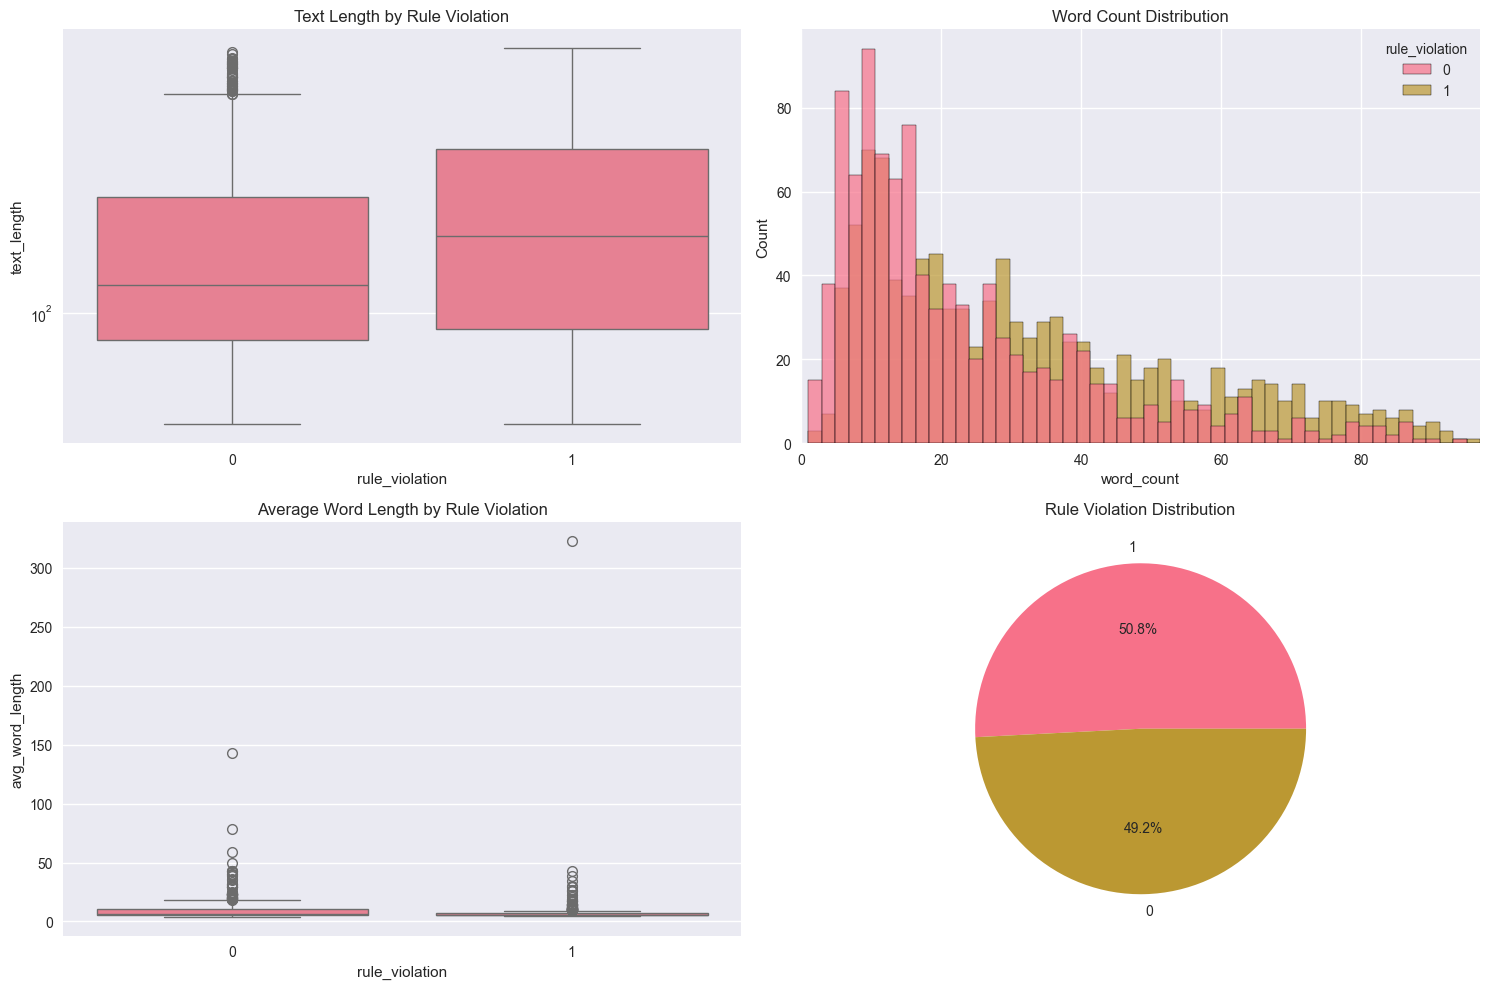


🔍 DATASET-SPECIFIC ANALYSIS:

Rule violations by subreddit (top 10):
                 count      mean
subreddit                       
legaladvice        213  0.788732
AskReddit          152  0.480263
soccerstreams      139  0.028777
personalfinance    125  0.696000
relationships      106  0.613208
The_Donald          94  0.553191
TwoXChromosomes     87  0.459770
news                65  0.584615
movies              56  0.375000
videos              50  0.400000

Rule violations by rule type (top 10):
                                                    count      mean
rule                                                               
No legal advice: Do not offer or request legal ...   1017  0.583088
No Advertising: Spam, referral links, unsolicit...   1012  0.432806

🤖 BUILDING BASELINE MODEL:
----------------------------------------
Preprocessing text...
Fitting TF-IDF vectorizer...
TF-IDF matrix shape: (2029, 4171)
Performing cross-validation...
Baseline CV F1-macro: 0.7385 (±0.0301

In [44]:
# Main execution
if __name__ == "__main__":
    # Load data
    train_df, test_df, sample_sub = load_and_validate_data()
    
    if train_df is not None:
        # Explore data
        target_dist, class_imbalance = explore_data(train_df, test_df, sample_sub)
        
        # Analyze text features
        text_stats = analyze_text_features(train_df)
        
        # Build baseline model
        lr_model, tfidf, X, y = build_baseline_model(train_df, test_df)
        
        # Create submission
        submission = create_submission(lr_model, tfidf, X, y, test_df, sample_sub)
        
        # Record findings
        print("\n" + "="*60)
        print("📋 FINDINGS SUMMARY:")
        print("="*60)
        print(f"- Class imbalance: {class_imbalance:.1f}%")
        print(f"- Average comment length: {train_df['word_count'].mean():.0f} words")
        print(f"- Median comment length: {train_df['word_count'].median():.0f} words")
        print(f"- Text length range: {train_df['text_length'].min()}-{train_df['text_length'].max()} chars")
        print(f"- TF-IDF features: {X.shape[1]:,}")
        print(f"- Unique subreddits: {train_df['subreddit'].nunique()}")
        print(f"- Unique rules: {train_df['rule'].nunique()}")
        print("\n✅ Baseline pipeline complete!")